<a href="https://colab.research.google.com/github/nikhardoshi/DiamondsPricePrediction/blob/main/Diamond_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler,OrdinalEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import metrics 
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
!pip install eli5 
import eli5
from eli5.sklearn import PermutationImportance

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/Microsoft course proj datasets/Copy of Diamond Price Prediction.csv')

# **EDA**

In [ ]:
data.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


In [ ]:
for i in ['clarity','cut','color']:
  print('\n')
  print(data[i].value_counts())



SI1     13065
VS2     12258
SI2      9194
VS1      8171
VVS2     5066
VVS1     3655
IF       1790
I1        741
Name: clarity, dtype: int64


Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: cut, dtype: int64


G    11292
E     9797
F     9542
H     8304
D     6775
I     5422
J     2808
Name: color, dtype: int64


In [ ]:
data.describe()

,Unnamed: 0,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,26970.500000,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,15571.281097,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,1.000000,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,13485.750000,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,26970.500000,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,40455.250000,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,53940.000000,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


Dropping the column Unnamed: 0 as it is nothing but index.

Also the numerical data needs scaling. The ordinal needs label encoding.

It also seems that there may be some outliers. SO checking them .

In [ ]:
data.drop(['Unnamed: 0'],axis=1,inplace=True)

# **Data Visualization**

In [ ]:
cols=data.columns
def display_plot(xline,dataset,typ,rows=2,coll=2,fig=[8,6],y=None,hue=None):
  fig,axes = plt.subplots(rows,coll,figsize=fig)
  i=0 
  for j in range(0,len(xline)):
    if j%coll==0 and j!=0:
      i+=1
    if typ=='count':
      sns.countplot(ax=axes[i,j%coll],data=dataset, x=xline[j],hue=hue)
    elif typ=='hist':
      sns.histplot(ax=axes[i,j%coll],data=dataset,x=xline[j],y=y)
    elif typ=='scatter':
      sns.scatterplot(ax=axes[i,j%coll],data=dataset,x=xline[j],y=y)
    elif typ=='line':
      sns.lineplot(ax=axes[i,j%coll],data=dataset,x=xline[j],y=y)
#Error that I had while defining function: 
#https://stackoverflow.com/questions/24719368/syntaxerror-non-default-argument-follows-default-argument

#Another error when trying to display the numeric data
#https://stackoverflow.com/questions/52273546/matplotlib-typeerror-axessubplot-object-is-not-subscriptable

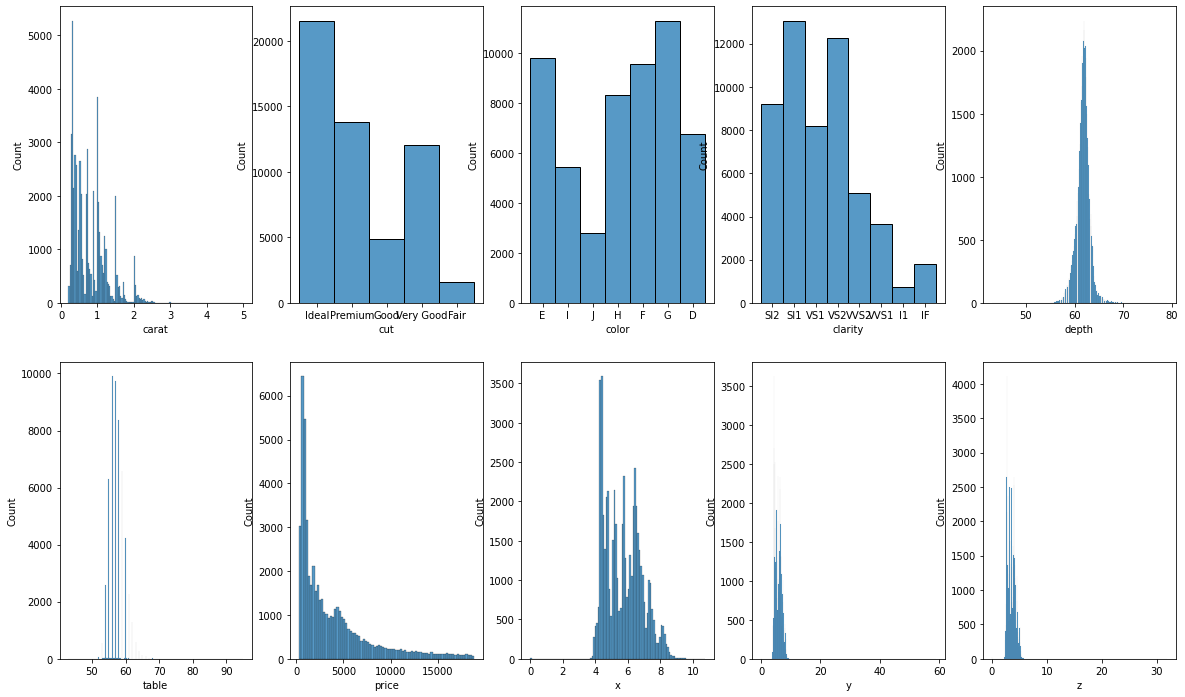

In [ ]:
display_plot(xline=cols,dataset=data,typ='hist',fig=[20,12],rows=2,coll=5)

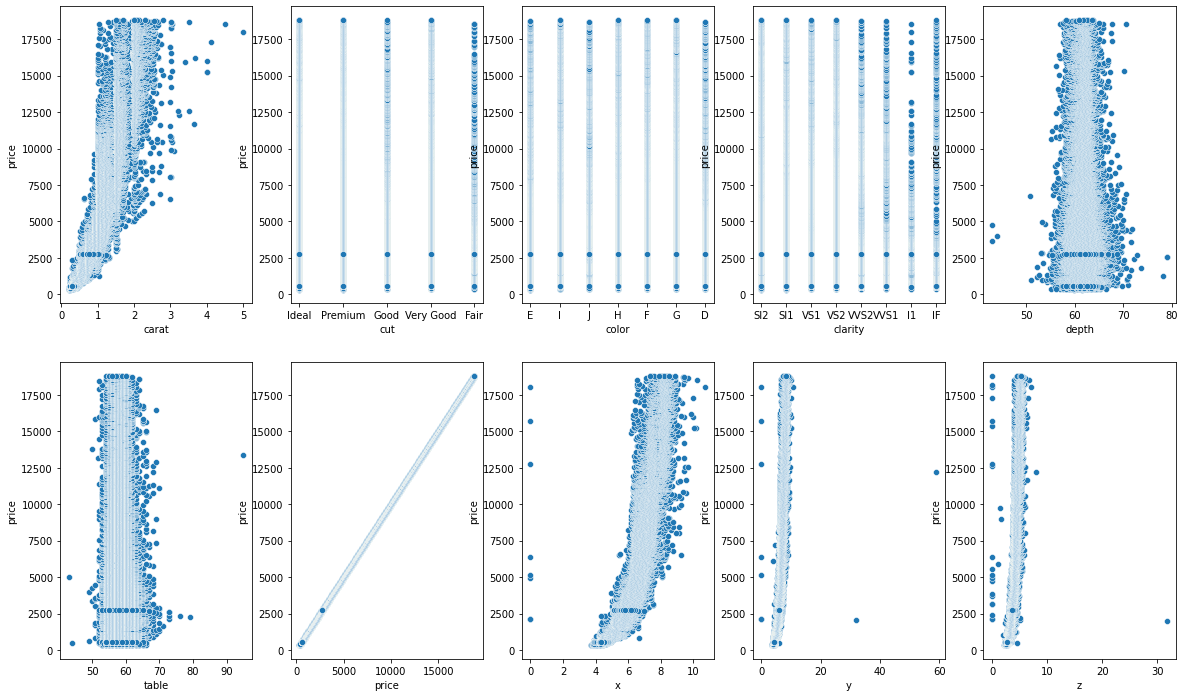

In [ ]:
display_plot(xline=cols,dataset=data,typ='scatter',y='price',fig=[20,12],rows=2,coll=5)

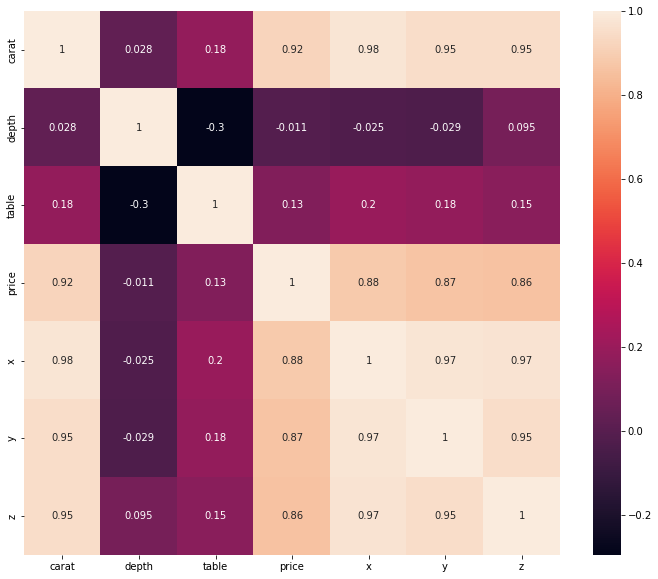

In [ ]:
plt.figure(figsize=[12,10])
sns.heatmap(data.corr(),annot=True)

# **Data Preprocessing**

**Removing outliers**

In [ ]:
data[data['x']<3.5]
data[(data['y']<3) | (data['y']>20)]
data[(data['z']<1.5) | (data['z']>8)].shape
data[(data['table']<50) | (data['table']>73)]
data[(data['depth']<50) | (data['depth']>73)]
data[(data['carat']>=4)]

,carat,cut,color,clarity,depth,table,price,x,y,z
25998,4.01,Premium,I,I1,61.0,61.0,15223,10.14,10.10,6.17
25999,4.01,Premium,J,I1,62.5,62.0,15223,10.02,9.94,6.24
26444,4.00,Very Good,I,I1,63.3,58.0,15984,10.01,9.94,6.31
27130,4.13,Fair,H,I1,64.8,61.0,17329,10.00,9.85,6.43
27415,5.01,Fair,J,I1,65.5,59.0,18018,10.74,10.54,6.98
27630,4.50,Fair,J,I1,65.8,58.0,18531,10.23,10.16,6.72


In [ ]:
data=data[data['x']>=3.5]
data=data[(data['y']>=3) | (data['y']<=20)]
data=data[(data['z']>=1.5) | (data['z']<=8)]
data=data[(data['depth']>=50) | (data['depth']<=73)]
data=data[(data['table']>=50) | (data['table']<=73)]
data=data[(data['carat']<=4)]

In [ ]:
data.shape

(53927, 10)

**Label Encoding and Data scaling using pipelines**

In [ ]:
numcols=['carat','depth','table','x','y','z']
catcols=['cut','color','clarity']
num_scaler=StandardScaler()
cat_proc=Pipeline(steps=
                  [('encoding',OrdinalEncoder()),
                  ('scaling',StandardScaler())])

preprocessing=ColumnTransformer(
    transformers=[
        ('num',num_scaler,numcols),
        ('cat',cat_proc,catcols)
    ])

In [ ]:
X=data.copy()
y=X.pop('price')

**Using the pipeline**

In [ ]:
X=preprocessing.fit_transform(X)

In [ ]:
X

array([[-1.20049255, -0.17394016, -1.09974674, ..., -0.53839857,
        -0.93706914, -0.48452444],
       [-1.24279681, -1.36084021,  1.58608355, ...,  0.43482637,
        -0.93706914, -1.06445895],
       [-1.20049255, -3.38555207,  3.37663708, ..., -1.51162352,
        -0.93706914,  0.09541007],
       ...,
       [-0.20634258,  0.73368929,  1.13844517, ...,  1.40805132,
        -1.52495991, -1.06445895],
       [ 0.13209146, -0.52302841,  0.24316841, ...,  0.43482637,
         0.82660319, -0.48452444],
       [-0.10058194,  0.31478339, -1.09974674, ..., -0.53839857,
        -1.52495991, -0.48452444]])

In [ ]:
x1=X[:25000]
y1=y[:25000]

# **Model Selection**

In [ ]:
def model_selection(X,y,model):
  X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)
  model.fit(X_train,y_train)
  ypred=model.predict(X_test)
  print('MAE:', mean_absolute_error(y_test, ypred))
  print("R^2:",metrics.r2_score(y_test, ypred))

In [ ]:
models_list=[LinearRegression(), RandomForestRegressor(), DecisionTreeRegressor(), XGBRegressor()]
for i in models_list:
  print(i)
  model_selection(X,y,i) 
  print('\n')

LinearRegression()
MAE: 843.5641227782164
R^2: 0.888011263366793


RandomForestRegressor()
MAE: 270.40765858446184
R^2: 0.9812758540422566


DecisionTreeRegressor()
MAE: 350.7804109182614
R^2: 0.9665951247861924


XGBRegressor()
[20:11:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE: 361.3058831996264
R^2: 0.9708667983449966




Thus RandomForestRegressor is the BEST option.